### **Задание лабораторной**
1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите следующие модели:
 - одну из линейных моделей (линейную или полиномиальную регрессию при решении задачи регрессии, логистическую регрессию при решении задачи классификации);
 - SVM;
 - дерево решений.
5. Оцените качество моделей с помощью двух подходящих для задачи метрик. Сравните качество полученных моделей.
6. Постройте график, показывающий важность признаков в дереве решений.
7. Визуализируйте дерево решений или выведите правила дерева решений в текстовом виде.

## Описание датасета: Рекомендация по выбору сельскохозяйственной культуры

### **Общая информация**
Данный датасет предназначен для построения модели классификации, которая определяет наиболее подходящую культуру для выращивания на основе агрохимических и климатических параметров. Он применяется в системах поддержки принятия решений в сельском хозяйстве, включая точное земледелие.

### **Признаки (входные переменные):**
- **N** — содержание азота в почве (мг/кг)
- **P** — содержание фосфора в почве (мг/кг)
- **K** — содержание калия в почве (мг/кг)
- **temperature** — средняя температура воздуха (в градусах Цельсия)
- **humidity** — средняя относительная влажность воздуха (в процентах)
- **ph** — уровень кислотности почвы (pH)
- **rainfall** — количество осадков (в миллиметрах)

### **Целевая переменная (выход):**
- **label** — наиболее подходящая культура для выращивания (например, rice, maize, cotton и др.)

**Импортируем библиотеки**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.tree import plot_tree


**Загрузка и первичный анализ данных**


In [ ]:
# Загрузка данных
df = pd.read_csv("Crop_recommendation.csv")

print("Размер датасета:", df.shape)
display(df.head())

print("\nКоличество пропущенных значений:")
print(df.isnull().sum())

print("\nКоличество уникальных культур:", df['label'].nunique())
print("Список культур:", df['label'].unique())


Размер датасета: (2200, 8)


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice



Количество пропущенных значений:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

Количество уникальных культур: 22
Список культур: ['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']


**Предобработка данных**

Нужно закодировать label для дальнейшей работы классификации
Использую обычный енкодер для лейбра. По сути склерновские алгоритмы должны понять что это просто закодированное число

In [ ]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

X = df.drop(['label', 'label_encoded'], axis=1)
y = df['label_encoded']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Метки:", label_mapping)


Соответствие меток: {'apple': np.int64(0), 'banana': np.int64(1), 'blackgram': np.int64(2), 'chickpea': np.int64(3), 'coconut': np.int64(4), 'coffee': np.int64(5), 'cotton': np.int64(6), 'grapes': np.int64(7), 'jute': np.int64(8), 'kidneybeans': np.int64(9), 'lentil': np.int64(10), 'maize': np.int64(11), 'mango': np.int64(12), 'mothbeans': np.int64(13), 'mungbean': np.int64(14), 'muskmelon': np.int64(15), 'orange': np.int64(16), 'papaya': np.int64(17), 'pigeonpeas': np.int64(18), 'pomegranate': np.int64(19), 'rice': np.int64(20), 'watermelon': np.int64(21)}


**Проверка сбалансированности классов в обучающей и тестовой выборках**

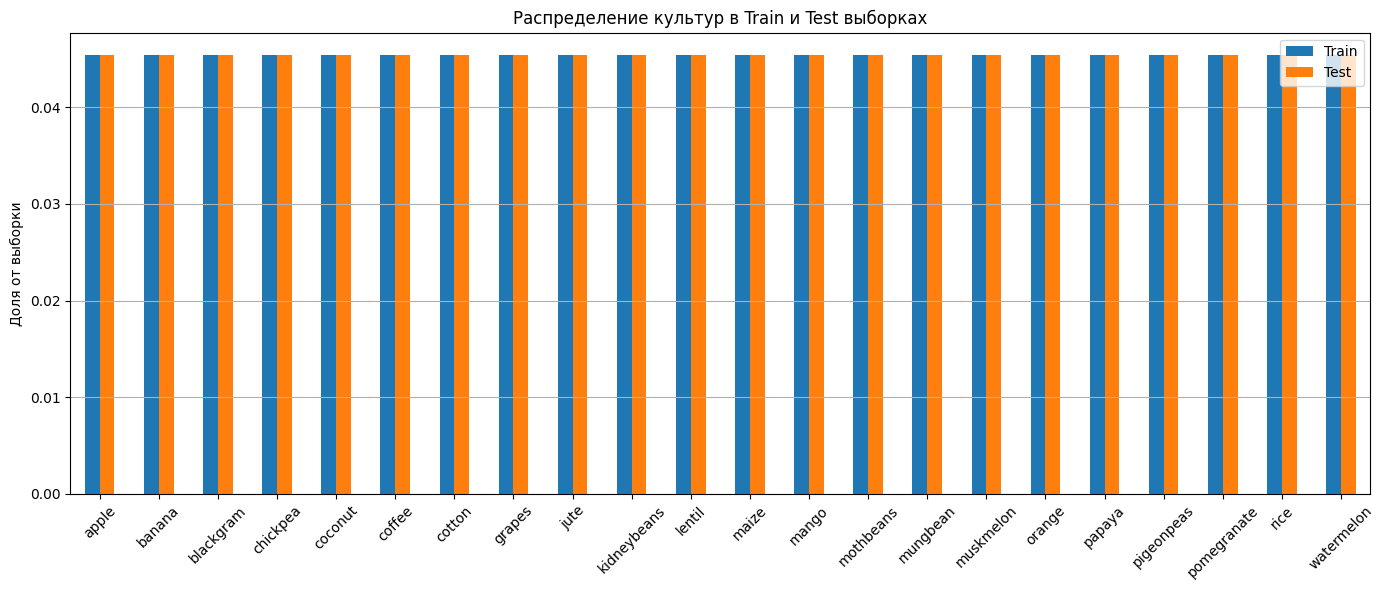

In [ ]:
y_train_labels = le.inverse_transform(y_train)
y_test_labels = le.inverse_transform(y_test)
train_distribution = pd.Series(y_train_labels).value_counts(normalize=True).sort_index()
test_distribution = pd.Series(y_test_labels).value_counts(normalize=True).sort_index()
distribution_df = pd.DataFrame({
    'Train': train_distribution,
    'Test': test_distribution
})

distribution_df.plot(kind='bar', figsize=(14, 6), title='Распределение культур в Train и Test выборках')
plt.ylabel("Доля от выборки")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


## Обучение моделей и оценка качества

Будут обучены три модели классификации: логистическая регрессия, метод опорных векторов и дерево решений. После обучения модели сравниваются по метрикам Accuracy и F1-Score на тестовой выборке.

In [ ]:
# Объявим модели
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Обучим и оценим
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted') 
    results[name] = {"Accuracy": acc, "F1 Score": f1}
    print(f"=== {name} ===")
    print(classification_report(y_test, preds, target_names=le.classes_))
    print()

# Таблица сравнения
results_df = pd.DataFrame(results).T
display(results_df)


=== Logistic Regression ===
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       0.95      1.00      0.98        20
    chickpea       1.00      1.00      1.00        20
     coconut       0.95      1.00      0.98        20
      coffee       1.00      1.00      1.00        20
      cotton       0.95      1.00      0.98        20
      grapes       1.00      1.00      1.00        20
        jute       0.83      1.00      0.91        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.94      0.85      0.89        20
       maize       1.00      0.95      0.97        20
       mango       0.95      1.00      0.98        20
   mothbeans       0.90      0.90      0.90        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange       1.00      0.95      0.97        20

C:\Users\aslan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,Accuracy,F1 Score
Logistic Regression,0.972727,0.972464
SVM,0.984091,0.984038
Decision Tree,0.979545,0.979423


**Важность признаков в дереве решений**

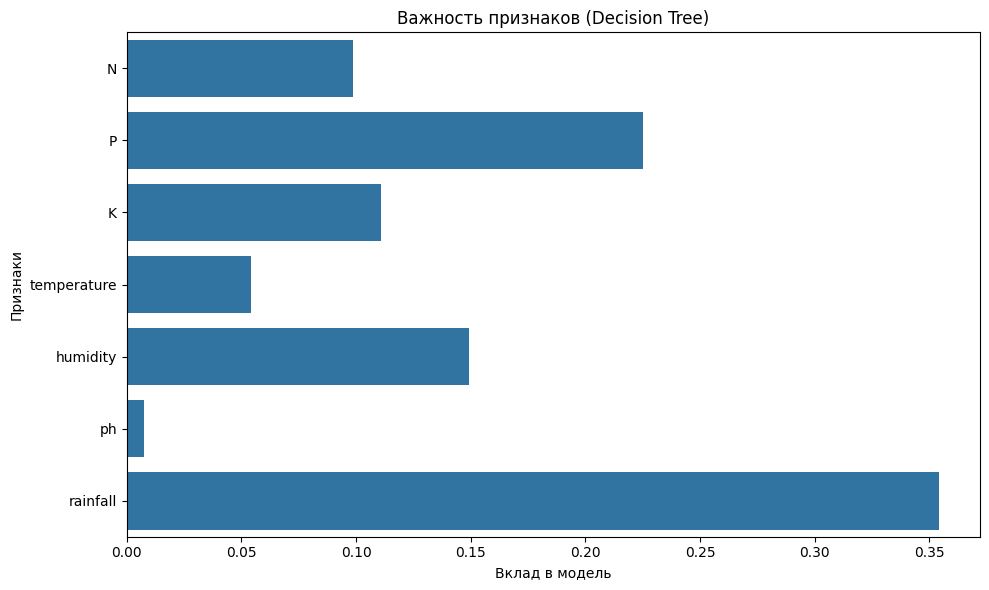

In [9]:
# Получим важности признаков
importances = models["Decision Tree"].feature_importances_
feature_names = X.columns

# Построим график
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Важность признаков (Decision Tree)")
plt.xlabel("Вклад в модель")
plt.ylabel("Признаки")
plt.tight_layout()
plt.show()


**Визуализация дерева решений**

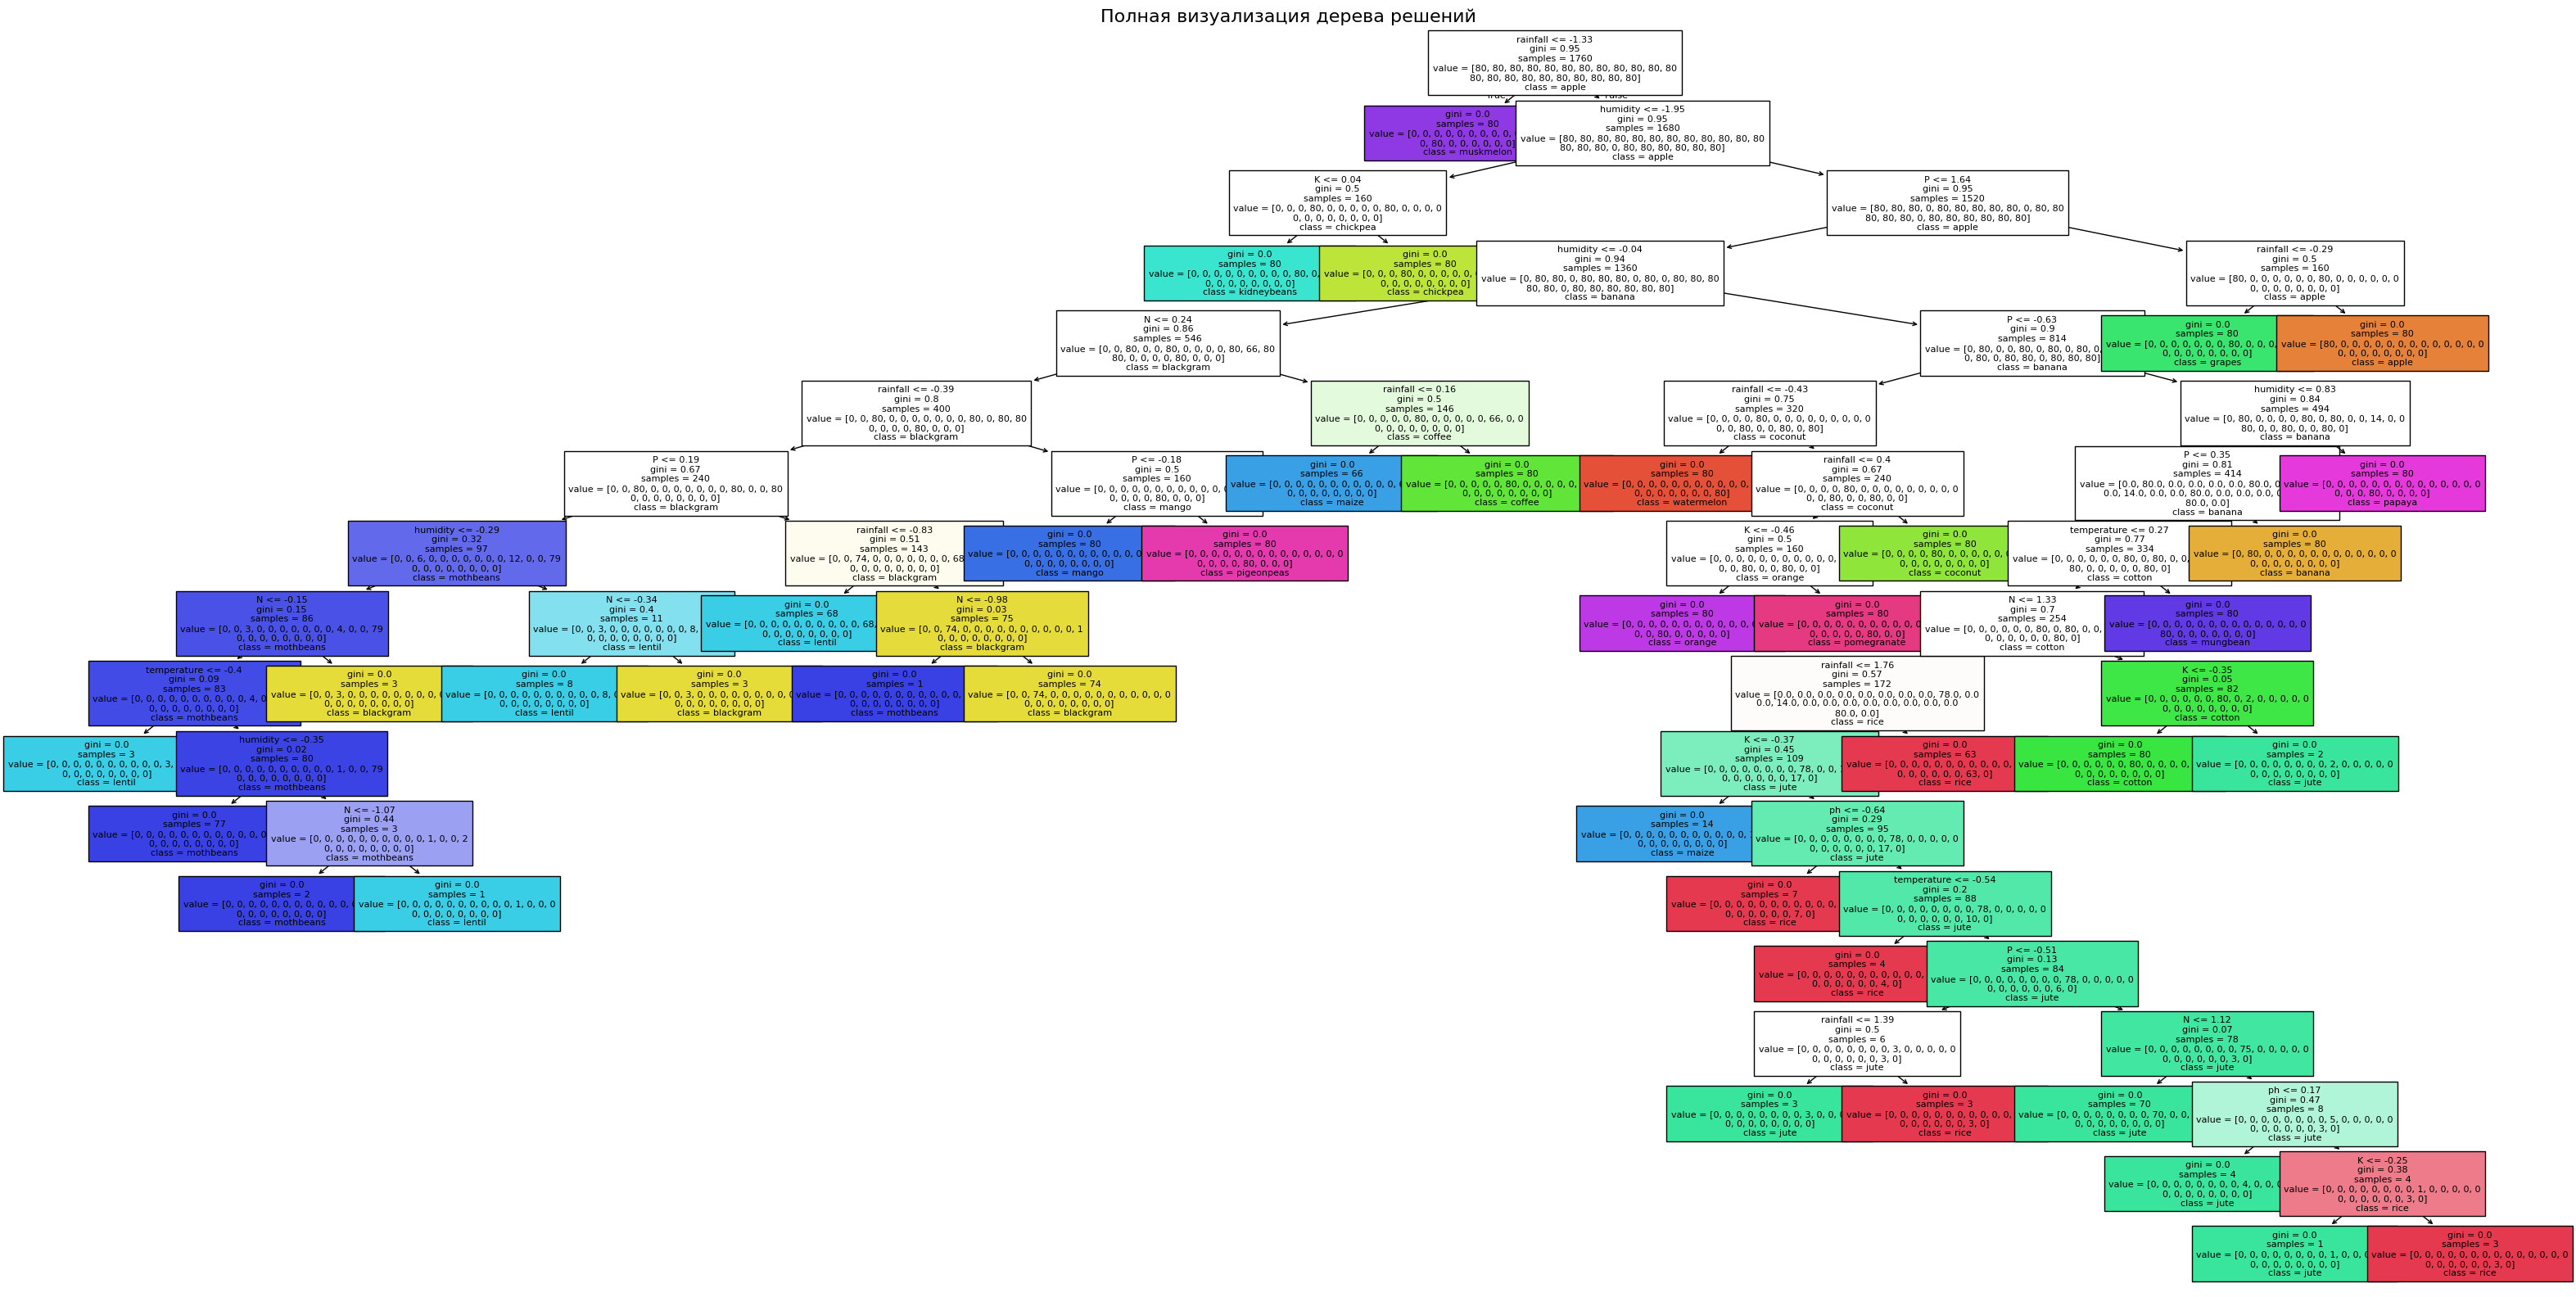

In [16]:
plt.figure(figsize=(40, 20))  # увеличиваем холст
plot_tree(
    models["Decision Tree"],
    feature_names=X.columns,
    class_names=le.classes_,
    filled=True,
    fontsize=8,
    precision=2  # округление чисел для читаемости
)
plt.title("Полная визуализация дерева решений", fontsize=16)
plt.show()


In [17]:
from sklearn.tree import export_text

tree_rules = export_text(models["Decision Tree"], feature_names=list(X.columns), max_depth=3)
print(tree_rules)


|--- rainfall <= -1.33
|   |--- class: 15
|--- rainfall >  -1.33
|   |--- humidity <= -1.95
|   |   |--- K <= 0.04
|   |   |   |--- class: 9
|   |   |--- K >  0.04
|   |   |   |--- class: 3
|   |--- humidity >  -1.95
|   |   |--- P <= 1.64
|   |   |   |--- humidity <= -0.04
|   |   |   |   |--- truncated branch of depth 9
|   |   |   |--- humidity >  -0.04
|   |   |   |   |--- truncated branch of depth 14
|   |   |--- P >  1.64
|   |   |   |--- rainfall <= -0.29
|   |   |   |   |--- class: 7
|   |   |   |--- rainfall >  -0.29
|   |   |   |   |--- class: 0

